In [3]:
a = 4
for i in [a]:
    print(a)
    

[4]


In [13]:
%%writefile ../../src/features/feature_utils.py
# %load ../../src/feature/feature_utils.py
# %%writefile ../../src/features/feature_utils.py
"""
Author: Jim Clauwaert
Created in the scope of my PhD
"""


import pandas as pd
import numpy as np


def AlignSequences(dfSequences, pw=False):
    
    """Align sequences with eachother in the dataframe, adding '-' for 
    missing nucleotides before and after shorter sequences, and changing the 35- and 10-box 
    reference regions accordingly
    
    Parameters
    -----------
    dfSequences : DataFrame
        Dataframe containing columns sequence and reference start regions
        DataFrame.columns has to contain ['sequence', '35boxstart', '10boxstart']
    
    Returns
    --------
    dfAlignedSequences : Dataframe 
        Dataframe containing aligned sequences
    """
    if pw is True:
        
        start35Box_1 = dfSequences['35boxstart_1'].values 
        start35Box_2 = dfSequences['35boxstart_2'].values 
        start35BoxMax = start35Box_1.max() if start35Box_1.max()>start35Box_2.max() else start35Box_2.max()
        
        dfAlignedSequences = dfSequences.copy()
          
        for i in range(1,3):
            
            sequences = dfSequences['sequence_{}'.format(i)].values 
            start35Box = dfSequences['35boxstart_{}'.format(i)].values 
            start10Box = dfSequences['10boxstart_{}'.format(i)].values 

            difLength = start35BoxMax-start35Box

            sequenceAligned = ["-" *difLength[u]+sequences[u] if difLength[u]>=0 else sequences[u][abs(difLength[u]):] for u in range(np.shape(sequences)[0]) ]
            start35Box = np.array([start35Box[u]+difLength[u] for u in range(np.shape(sequences)[0])])
            start10Box = np.array([start10Box[u]+difLength[u] for u in range(np.shape(sequences)[0])])

            maxLength = max([len(sequenceAligned[u]) for u in range(np.shape(sequenceAligned)[0])])
            difLength = [maxLength - len(sequenceAligned[u]) for u in range(np.shape(sequenceAligned)[0])]
            sequences = [sequenceAligned[u]+ '-'*difLength[u] for u in range(np.shape(sequenceAligned)[0]) ]

            dfAlignedSequences['sequence_{}'.format(i)] = sequences
            dfAlignedSequences['35boxstart_{}'.format(i)] = start35Box
            dfAlignedSequences['10boxstart_{}'.format(i)] = start10Box


        
    else:
        
        sequences = dfSequences['sequence'].values 
        start35Box = dfSequences['35boxstart'].values 
        start10Box = dfSequences['10boxstart'].values 

        difLength = start35Box.max()-start35Box

        sequenceAligned = ["-" *difLength[u]+sequences[u] if difLength[u]>=0 else sequences[u][abs(difLength[u]):] for u in range(np.shape(sequences)[0]) ]
        start35Box = np.array([start35Box[u]+difLength[u] for u in range(np.shape(sequences)[0])])
        start10Box = np.array([start10Box[u]+difLength[u] for u in range(np.shape(sequences)[0])])

        maxLength = max([len(sequenceAligned[u]) for u in range(np.shape(sequenceAligned)[0])])
        difLength = [maxLength - len(sequenceAligned[u]) for u in range(np.shape(sequenceAligned)[0])]
        sequences = [sequenceAligned[u]+ '-'*difLength[u] for u in range(np.shape(sequenceAligned)[0]) ]

        dfAlignedSequences = dfSequences.copy()
        dfAlignedSequences['sequence'] = sequences
        dfAlignedSequences['35boxstart'] = start35Box
        dfAlignedSequences['10boxstart'] = start10Box

    return dfAlignedSequences


def CreateDummyNucleotideFeatures(sequences, posRange):
    
    """Create dummy dataframe of nucleotides for two regions surrounding 35- and 10-box
    
    Parameters
    -----------
    sequences : 1-dimensional numpy array
        numpy array containing an array of sequences (str)
        
    posRange : tuple, 2-element array
        tuple containing range of the sequence off of which dummy features will be created. This range is 
        used to create column names for the obtained dummy features
          
    Returns
    --------
    dfDummyDataFrame : Dataframe 
        Dataframe containing dummy features
    """
    
    # Create Position Matrix
    nucleotideMatrix = ChopStringVector(sequences)
    # Convert to Dataframe
    posRangeCol = [str(x) for x in range(posRange[0],posRange[1])]
    dfNucleotideMatrix = pd.DataFrame(nucleotideMatrix, columns = posRangeCol)

    # Create dummy Matrix
    dfDummyNucleotideFeatures =  pd.get_dummies(dfNucleotideMatrix)


    return dfDummyNucleotideFeatures


def ChopStringVector(strings):
    
    """Chops a vector of strings (equal length) into a matrix of characters, with each row containing a separate 
    string
    
    Parameters
    -----------
    strings : 1-dimensional numpy array
        numpy array containing array of strings 
   
    Returns
    --------
    charMatrix : 2-dimensional numpy array 
        Matrix containing chopped up strings
    """
    
    charMatrix = np.empty([len(strings),len(strings[0])],dtype=np.dtype(str,1))
    strings=np.array(strings)
    for i in range(0,len(strings)):
        charMatrix[i] = [strings[i][u] for u in range(0,len(strings[i]))]

    return charMatrix 

def CreateFeaturesFromData(data, seqRegions, pw, shuffle=True):
    
    """Creates features from
    
    data: string
        PATH or filename of dataset
    
    seqRegions : tuple,list
        List containing two positional ranges from which features are derived, respectively starting from first
        nucleotide of 35-box and 10-box
        Example: [[0,6],[0,6]] returns positional features of the range of the -35box and -10box respectively
   
    
    
    """
    if type(data) is not list:
        data = [data]
    
    dfFeatureBoxList = []
    dfDatasetList = []
    for d in data:
        dfDataset = pd.read_csv(d)
        dfDataset = AlignSequences(dfDataset, pw)
        if shuffle is True:
            dfDataset = dfDataset.reindex(np.random.permutation(dfDataset.index))
        if pw is True:
            dfFeatureBox = PositionalFeaturesPW(dfDataset, seqRegions)
        else:
            dfFeatureBox = PositionalFeatures(dfDataset, seqRegions)
        
        dfFeatureBoxList.append(dfFeatureBox)
        dfDatasetList.append(dfDataset)

    featureBox = pd.concat(dfFeatureBoxList)
    dfDataset = pd.concat(dfDatasetList)
    
    return dfDataset, featureBox


def CreateFullDummyDataFrame(posRange):
    
    """Creates a dummy nucleotide feature dataframe over a specified range for promotors. '-' is added for 
    nucleotide positions <-35 or >-3
    
    Parameters
    -----------
    posRange : tuple
        Range over which the full nucleotide dummy dataframe is created 
     
    Returns
    --------
    fullDummyDataframe : DataFrame
        Dataframe containing all possible dummy features for positional nucleotides 
    """    
    
    posRangeCol = [str(x) for x in range(posRange[0],posRange[1])]
    
    length = len(posRangeCol)
    a = np.empty([length],dtype=np.dtype(str,1))
    c = np.empty([length],dtype=np.dtype(str,1))
    t = np.empty([length],dtype=np.dtype(str,1))
    g = np.empty([length],dtype=np.dtype(str,1))
    dash = np.empty([length],dtype=np.dtype(str,1))
    a.fill('A')
    t.fill('T')
    c.fill('C')
    g.fill('G')
    dash.fill('A')
    dash[:(-posRange[0]-35)]='-'
    dash[(-posRange[0]-3):]='-'
    dataframe = pd.DataFrame(np.vstack((a,t,c,g,dash)),columns=posRangeCol)
    fullDummyDataFrame = pd.get_dummies(dataframe)
    
    return fullDummyDataFrame

def PositionalFeatures(dfDataset, seqRegions):
    
    """Create position features for a given promoter dataset. Returns dummy dataset.
    
    Parameters
    -----------
    dfDataset : DataFrame
        Dataframe containing columns sequence and reference start regions
        columnNames = (sequence, 35boxstart, 10boxstart)
        
    seqRegions : tuple,list
        List containing two positional ranges from which features are derived, respectively starting from first
        nucleotide of 35-box and 10-box
        Example: [[0,6],[0,6]] returns positional features of the range of the -35box and -10box respectively.
        
    shuffle : Boolean
        Shuffles input dataset
        
    Returns
    --------
        
    dfDataset : DataFrame
        Shuffled dataset
        
    dfPositionBox : DataFrame 
        Dataframe containing dummy arguments

    
    """
    
    # Selecting regions
    
    dfDataset['sequence'] = dfDataset['sequence'].str.upper()
    sequences = dfDataset['sequence'].values 
    start35Box = dfDataset['35boxstart'].values 
    start10Box = dfDataset['10boxstart'].values 
    
    seqRegions = np.array(seqRegions)
    posRange = [seqRegions[0,0]-35,seqRegions[1,1]-12]
        
    reg35 = np.array(seqRegions[0])
    reg10 = np.array(seqRegions[1])
    
    box35 = SelectRegions(sequences, reg35, start35Box)
    box10 = SelectRegions(sequences, reg10, start10Box)
    spacer = start10Box-start35Box-6
    
    spacerM = [u-17 if u-17>0 else 0 for u in spacer]
    spacerL = [abs(u-17) if u-17<0 else 0 for u in spacer]
    
    spacerBox = pd.DataFrame({'spacer_more':spacerM,'spacer_less':spacerL})
   
    # Creating features

    positionBox35 = CreateDummyNucleotideFeatures(box35, reg35-35)
    positionBox10 = CreateDummyNucleotideFeatures(box10, reg10-12)

    positionBoxSS = pd.concat([positionBox35,positionBox10], axis=1)
    
    dfTemplateDummyBox = CreateFullDummyDataFrame(posRange)
    dfFinalBox = pd.DataFrame(0, range(len(sequences)),columns=dfTemplateDummyBox.columns)
    
    colNamesResult = positionBoxSS.columns
    for i in colNamesResult:
        if i in dfFinalBox.columns:
            dfFinalBox[i] = positionBoxSS[i]
    
    dfPositionBox = pd.concat([dfFinalBox, spacerBox], axis=1)
    
    return dfPositionBox

def PositionalFeaturesPW(dfDataset, seqRegions, subtract=True):
    
    """Create position features of a pairwise promoter dataset. Returns matrix of dummy features.
    
    Parameters
    -----------
    dfDataset : DataFrame
        Dataframe containing promoter data from pairwise dataset
        columnNames = (sequence_1, 35boxstart_1, 10boxstart_1, sequence_2, 35boxstart_2, 10boxstart_2)
        
    seqRegions : tuple,list
        List containing two positional ranges from which features are derived, respectively starting from first
        nucleotide of 35-box and 10-box
        Example: [[0,6],[0,6]] returns positional features of the range of the -35box and -10box respectively
        
    shuffle : Boolean
        Shuffles input dataset
        
    merge : Boolean
        subtract dummy features of pairwise sequences. Reduces returned features by half
        
    Returns
    --------
    dfPositionBox : DataFrame 
        Dataframe containing dummy arguments
    dfDataset : DataFrame
        Shuffled dataset
    
    """    
    
    dfDataset['sequence_1'] = dfDataset['sequence_1'].str.upper()
    dfDataset['sequence_2'] = dfDataset['sequence_2'].str.upper()
    
    dfDataset1 = pd.DataFrame(dfDataset[['ID_1','sequence_1','mean_score_1','35boxstart_1','10boxstart_1']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
    dfDataset2 = pd.DataFrame(dfDataset[['ID_2','sequence_2','mean_score_2','35boxstart_2','10boxstart_2']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])

    
    dfPositionBoxSeq1 = PositionalFeatures(dfDataset1, seqRegions)
    dfPositionBoxSeq2 = PositionalFeatures(dfDataset2, seqRegions)
  
    if subtract is True: 
        dfPositionBox = pd.DataFrame(np.subtract(dfPositionBoxSeq1.values,dfPositionBoxSeq2.values),columns=dfPositionBoxSeq1.columns)
    else:
        dfPositionBox = pd.concat([dfPositionBoxSeq1, dfPositionBoxSeq2], axis=1)
   
    return dfPositionBox


    

def SelectRegions(sequences, ntRange, referencePoint=None):
    
    """Selects substring or sequence nucleotides 
    
    Parameters
    -----------
    sequences : 1-dimensional numpy array
        numpy array containing an array of sequences (str)    
        
    ntRange : tuple
        range of nucleotides with respect to a reference point
        
   referencePoint: 1-dimensional numpy array
       numpy array containing the positional reference point for each sequence given in 'sequences'
    
    Returns
    --------
    selectedNucleotides : 1-dimensional numpy array 
        numpy array containing the nucleotide fragments from each region
    """
    if referencePoint.all == None:
        selectedNucleotides = [sequences[u][ntRange[0]:ntRange[1]] for u in range(0,len(sequences))]
    else:
        selectedNucleotides = []
        for u in range(0,len(sequences)):
            pre = ntRange[0]+referencePoint[u]
            diff = ntRange[1]+referencePoint[u] -len(sequences[u])
            if pre<0 and diff>0:
                nucleotide = str(abs(pre)*'-')+sequences[u][ntRange[0]+referencePoint[u]-pre:
                                                            ntRange[1]+referencePoint[u]-diff] +diff*'-'
            elif pre<0 and diff<=0:
                nucleotide = str(abs(pre)*'-')+sequences[u][ntRange[0]+referencePoint[u]-pre:
                                                            ntRange[1]+referencePoint[u]]
            elif pre>=0 and diff>0:
                nucleotide = sequences[u][ntRange[0]+referencePoint[u]:ntRange[1]+referencePoint[u]-diff] +diff*'-'
            elif pre>=0 and diff<=0:
                nucleotide = sequences[u][ntRange[0]+referencePoint[u]:ntRange[1]+referencePoint[u]]
                
            selectedNucleotides.append(nucleotide)                             
    return selectedNucleotides


Overwriting ../../src/features/feature_utils.py


In [12]:
def SelectRegions(sequences, ntRange, referencePoint=None):
    
    """Selects substring or sequence nucleotides 
    
    Parameters
    -----------
    sequences : 1-dimensional numpy array
        numpy array containing an array of sequences (str)    
        
    ntRange : tuple
        range of nucleotides with respect to a reference point
        
   referencePoint: 1-dimensional numpy array
       numpy array containing the positional reference point for each sequence given in 'sequences'
    
    Returns
    --------
    selectedNucleotides : 1-dimensional numpy array 
        numpy array containing the nucleotide fragments from each region
    """
    if referencePoint.all == None:
        selectedNucleotides = [sequences[u][ntRange[0]:ntRange[1]] for u in range(0,len(sequences))]
    else:
        selectedNucleotides = []
        for u in range(0,len(sequences)):
            pre = ntRange[0]+referencePoint[u]
            diff = ntRange[1]+referencePoint[u] -len(sequences[u])
            if pre<0 and diff>0:
                nucleotide = str(abs(pre)*'-')+sequences[u][ntRange[0]+referencePoint[u]-pre:
                                                            ntRange[1]+referencePoint[u]-diff] +diff*'-'
            elif pre<0 and diff<=0:
                nucleotide = str(abs(pre)*'-')+sequences[u][ntRange[0]+referencePoint[u]-pre:
                                                            ntRange[1]+referencePoint[u]]
            elif pre>=0 and diff>0:
                nucleotide = sequences[u][ntRange[0]+referencePoint[u]:ntRange[1]+referencePoint[u]-diff] +diff*'-'
            elif pre>=0 and diff<=0:
                nucleotide = sequences[u][ntRange[0]+referencePoint[u]:ntRange[1]+referencePoint[u]]
                
            selectedNucleotides.append(nucleotide)                             
    return selectedNucleotides

def CreateDummyNucleotideFeatures(sequences, posRange):
    
    """Create dummy dataframe of nucleotides for two regions surrounding 35- and 10-box
    
    Parameters
    -----------
    sequences : 1-dimensional numpy array
        numpy array containing an array of sequences (str)
        
    posRange : tuple, 2-element array
        tuple containing range of the sequence off of which dummy features will be created. This range is 
        used to create column names for the obtained dummy features
          
    Returns
    --------
    dfDummyDataFrame : Dataframe 
        Dataframe containing dummy features
    """
    # Create Position Matrix
    nucleotideMatrix = ChopStringVector(sequences)
    # Convert to Dataframe
    posRangeCol = [str(x) for x in range(posRange[0],posRange[1])]
    dfNucleotideMatrix = pd.DataFrame(nucleotideMatrix, columns = posRangeCol)

    # Create dummy Matrix
    dfDummyNucleotideFeatures =  pd.get_dummies(dfNucleotideMatrix)


    return dfDummyNucleotideFeatures

def ChopStringVector(strings):
    
    """Chops a vector of strings (equal length) into a matrix of characters, with each row containing a separate 
    string
    
    Parameters
    -----------
    strings : 1-dimensional numpy array
        numpy array containing array of strings 
   
    Returns
    --------
    charMatrix : 2-dimensional numpy array 
        Matrix containing chopped up strings
    """
    
    charMatrix = np.empty([len(strings),len(strings[0])],dtype=np.dtype(str,1))
    strings=np.array(strings)
    for i in range(0,len(strings)):
        charMatrix[i] = [strings[i][u] for u in range(0,len(strings[i]))]

    return charMatrix 
def PositionalFeatures(dfDataset, seqRegions, shuffle=False):
    
    """Create position features for a given promoter dataset. Returns dummy dataset.
    
    Parameters
    -----------
    dfDataset : DataFrame
        Dataframe containing columns sequence and reference start regions
        columnNames = (sequence, 35boxstart, 10boxstart)
        
    seqRegions : tuple,list
        List containing two positional ranges from which features are derived, respectively starting from first
        nucleotide of 35-box and 10-box
        Example: [[0,6],[0,6]] returns positional features of the range of the -35box and -10box respectively.
        
    shuffle : Boolean
        Shuffles input dataset
        
    Returns
    --------
        
    dfDataset : DataFrame
        Shuffled dataset
        
    dfPositionBox : DataFrame 
        Dataframe containing dummy arguments

    
    """
    
    if shuffle is True:
        dfDataset = dfDataset.reindex(np.random.permutation(dfDataset.index))

    # Selecting regions
    
    dfDataset['sequence'] = dfDataset['sequence'].str.upper()
    sequences = dfDataset['sequence'].values 
    start35Box = dfDataset['35boxstart'].values 
    start10Box = dfDataset['10boxstart'].values 
    
    seqRegions = np.array(seqRegions)
    posRange = [seqRegions[0,0]-35,seqRegions[1,1]-12]
        
    reg35 = np.array(seqRegions[0])
    reg10 = np.array(seqRegions[1])
    
    box35 = SelectRegions(sequences, reg35, start35Box)
    box10 = SelectRegions(sequences, reg10, start10Box)
    spacer = start10Box-start35Box-6
    
    spacerM = [u-17 if u-17>0 else 0 for u in spacer]
    spacerL = [abs(u-17) if u-17<0 else 0 for u in spacer]
    
    spacerBox = pd.DataFrame({'spacer_more':spacerM,'spacer_less':spacerL})
   
    # Creating features
    positionBox35 = CreateDummyNucleotideFeatures(box35, reg35-35)
    positionBox10 = CreateDummyNucleotideFeatures(box10, reg10-12)

    positionBoxSS = pd.concat([positionBox35,positionBox10], axis=1)
    
    dfTemplateDummyBox = CreateFullDummyDataFrame(posRange)
    dfFinalBox = pd.DataFrame(0, range(len(sequences)),columns=dfTemplateDummyBox.columns)
    
    colNamesResult = positionBoxSS.columns
    for i in colNamesResult:
        if i in dfFinalBox.columns:
            dfFinalBox[i] = positionBoxSS[i]
    
    dfPositionBox = pd.concat([dfFinalBox, spacerBox], axis=1)

    
    if shuffle is True:
        return dfDataset, dfPositionBox
    else:
        return dfPositionBox


In [17]:
%pdb

Automatic pdb calling has been turned ON


In [20]:
import sys
sys.path.append("../../src")
import features.feature_utils as fu
import models.model_utils as mu
import plots.plot_utils as pu
import pandas as pd
import math
from sklearn.model_selection import GridSearchCV
import logging
import datetime as dt
import numpy as np

model = ['forestClass',None,None]
modelOpt = {'n_estimators':20}
k= 5
pw = True
step = 1
seqRegions = [[-20,14],[-7,12]]
data = '../../data/interim/pw_inbio_prom_lib.csv'
dataEnrich= '../../data/interim/pw_mutalik_prom_lib.csv'

dfDataset , featureBox = CreateFeaturesFromData(data, seqRegions, pw, shuffle=True)
dfEnrich, enrichBox = CreateFeaturesFromData(dataEnrich, seqRegions, pw, shuffle=True)



X_enrich = enrichBox.values
y_enrich = dfEnrich['rank']

X = featureBox.values
y = dfDataset['rank']

parModel = mu.SetupModel(model, modelOpt)

scores = mu.LearningCurveInSampleEnriched(dfDataset, featureBox, enrichBox, y, y_enrich, parModel, k, pw, step)

fig, ax1, ax2 = pu.LearningCurveInSampleEnriched(scores, k, step)

Progress 99.5%rogress 0.5%

In [5]:
featureBox.values[0]

NameError: name 'featureBox' is not defined

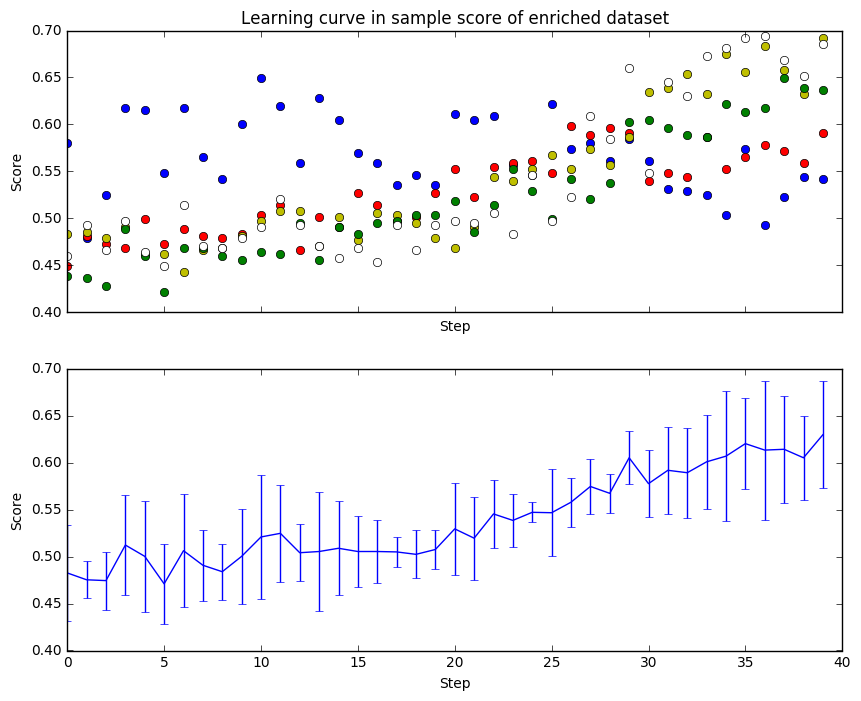

In [23]:
fig

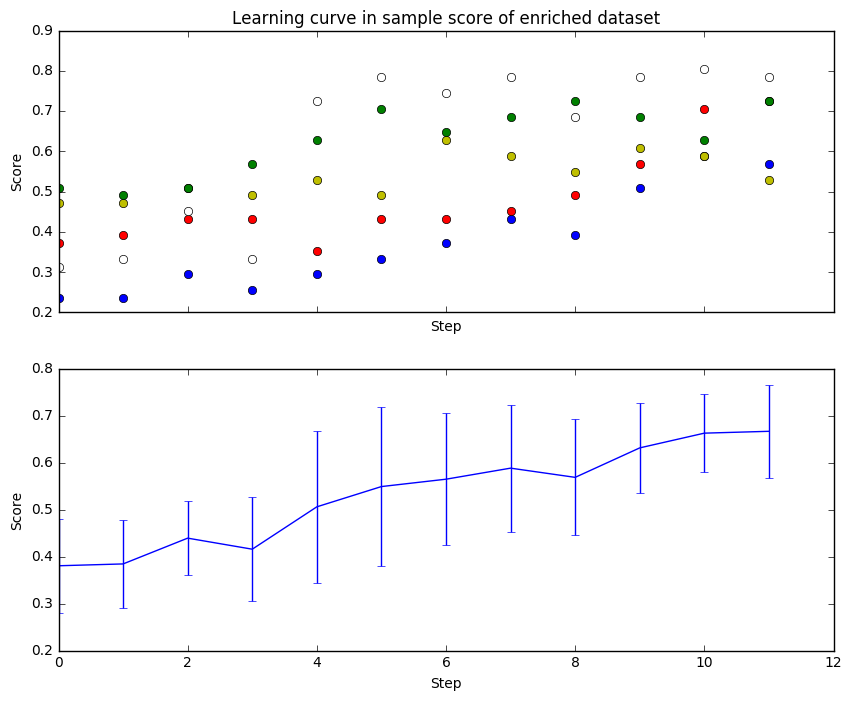

In [68]:
fig

In [19]:
dfDataset = pd.read_csv('../../data/interim/pw_anderson_prom_lib.csv')

In [20]:
dfDatasetShuffled , Box = PositionalFeaturesPW(dfDataset, [[0,6],[0,6]], shuffle=True)

In [21]:
plt.close('all')


# sequence region
seqRange = [-42,1]
ROI =  [[-5,14],[-8,12]]


#model selection and hyperparameters
regType = 'ridge'
kernel = 'poly'
poly= 3

# To be evaluated parameter(s)
parLabel = ['alpha']
parRange = [20] 



## OPTIONAL ##

testSize = 0.2 
k = 5 
kInner = 5
pdf = None

treeCount = 10
gamma = 0.1
alpha = 0.1
coef0 = 0.00
penalty = 0.1
epsilon = 1.95


parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0}

dfDatasetShuffled , featureBox = PositionalFeaturesPW(dfDataset, [[0,6],[0,6]], shuffle=True)
featureMatrix = featureBox.values

Xdf = featureBox
X = featureMatrix
y = dfDatasetShuffled['rank'].values

if len(parLabel) is 1: 
    scoresParCV, optimalParCV = KfoldCV(X,y,k,parModel,parLabel[0],parRange[0]) 
    #scoresParNCV, optimalParNCV, scoresNCV = nestedKfoldCV(X,y,k,kInner,parModel,parLabel[0],parRange[0])    
    meanScores = np.mean(np.ndarray.max(scoresParCV,axis=1))
    print("K FOLD CV \n---------- \n\n Maximum Score: ",np.max(scoresParCV), "\n Mean optimal score: ", meanScores ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-meanScores),2)))   , "\n Optimal parEval:\n", optimalParCV, "\n parEval Scores:\n", scoresParCV,"\n\n\n")
    #print("NESTED K FOLD CV \n----------------- \n\n Maximum Score: ",np.max(scoresParNCV), "\n Mean optimal score: ", np.mean(scoresParNCV) ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-np.mean(scoresParNCV)),2))) , "\n Optimal parEval:\n", optimalParNCV, "\n parEval Scores:\n", scoresParNCV,"\n\n\n")


NameError: name 'KfoldCV' is not defined

In [5]:
import matplotlib
import numpy as np
import math
import itertools
import sklearn
import warnings
import pandas as pd
import sklearn.linear_model
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
import mysql.connector as myconnect

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
###################################### FUNCTIONS ######################################
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### Query MySQL #######################################################################

def querySQL (database, query):
    config = {
    'user': 'root',
    'password': 'jim',
    'host': 'localhost',
    'database': database,
    'raise_on_warnings': True,
    }
    cnx = myconnect.connect(**config) 
    resultset = pd.read_sql_query(query,cnx)
    
    return resultset

#######################################################################################
### Give scores for subset of parameters ##############################################

def bestSubsetSelection(X_train, X_test, y_train, y_test, parCount, regType, alpha=0, poly=None):
    
    parameters = len(X[0])
    combinations = list(itertools.combinations(range(parameters),parCount))
    combinationsL = len(combinations)
    scores = np.empty([combinationsL])
    for i in range(0, combinationsL):
        
        reg = selectRegression(regType,alpha=alpha, poly=poly)
        reg.fit(X_train[:,combinations[i]], y_train)
        scores[i] = reg.score(X_test[:,combinations[i]], y_test)
        
    #Sort results (descending)
    indexMin = np.argsort(scores)
    sortedCombin =[combinations[u] for u in indexMin[::-1]]
    sortedScores =[scores[u] for u in indexMin[::-1]]
    #plt1 = plt.figure(1)
    #plt.plot(range(len(sortedScores)),sortedScores, 'ro')
    return sortedCombin, sortedScores

#######################################################################################
### Create full dummy dataframe #######################################################

def createFullDummyDF(positions, start35Box, start10Box):
    length = len(positions)
    a = np.empty([length],dtype=np.dtype(str,1))
    c = np.empty([length],dtype=np.dtype(str,1))
    t = np.empty([length],dtype=np.dtype(str,1))
    g = np.empty([length],dtype=np.dtype(str,1))
    dash = np.empty([length],dtype=np.dtype(str,1))
    a.fill('A')
    t.fill('T')
    c.fill('C')
    g.fill('G')
    dash.fill('A')
    dash[:start35Box[0]]='-'
    dash[(start35Box[0]+32):]='-'
    dataframe = pd.DataFrame(np.vstack((a,t,c,g,dash)),columns=positions)
    dummyTable = pd.get_dummies(dataframe)
    
    return dummyTable

######################################################################################
### Create position matrix ###########################################################

def createPositionMatrix(sequences):
    ntArray = np.empty([len(sequences),len(sequences[0])],dtype=np.dtype(str,1))
    sequences=np.array(sequences)
    for i in range(0,len(sequences)):
        ntArray[i] = [sequences[i][u] for u in range(0,len(sequences[i]))]
    
    return ntArray 

######################################################################################
### Create compatible position dataframe #############################################

def createPositionDF(seq, posRange, start35Box, start10Box):
    # Create Position Matrix
    posMatrix = createPositionMatrix(seq)
    # Convert to Dataframe
    posRangeCol = [str(x) for x in range(posRange[0],posRange[1])]
    dfPosMatrix = pd.DataFrame(posMatrix, columns = posRangeCol)

    # Create dummy Matrix
    dfDumPosMatrix =  pd.get_dummies(dfPosMatrix)


    return dfDumPosMatrix

#######################################################################################
### getParameter ######################################################################

def getParameters(parLabel, parRange):
    
    parameters = [np.zeros(parRange[u]) for u in range(len(parRange))]
 
 
    for i in range(len(parLabel)):
        if parLabel[i] is "alpha":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] is "gamma":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] is "C":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] is "coef0":
            parameters[i][:] = [math.pow(10,(u - np.around(parRange[i]/2))) for u in range(parRange[i])]
        elif parLabel[i] is "epsilon":
            parameters[i][:] = [0+2/parRange[i]*u for u in range(parRange[i])]
        elif parLabel[i] is "max_depth":
            parameters[i][:] = [u+1 for u in range(parRange[i])]
        elif parLabel[i] is 'min_samples':
            parameters[i][:] = [u+1 for u in range(parRange[i])]
        elif parLabel[i] is 'max_features':
            parameters[i][:] = [int(u+2) for u in range(parRange[i])]
        else:
            return print("not a valid parameter")
    
    parEval = {parLabel[u]:parameters[u] for u in range(len(parLabel))}
    return parEval

########################################################################################
### Evaluate Multiple Parameters #######################################################

def evaluateMultiPar(X, y, modelPar, parLabel, parRange):
    
    #data prep
    parEval = getParameters(parLabel,parRange)
    yMin, yMax = np.min(parEval[parLabel[0]]), np.max(parEval[parLabel[0]])
    xMin, xMax = np.min(parEval[parLabel[1]]), np.max(parEval[parLabel[1]])
    
    #model fitting
    reg = selectRegression(**modelPar)
    GS = GridSearchCV(reg, parEval)
    GS.fit(X,y)

    #plotting
    plt.figure("Model accuracy ifv model parameters")
    plt.imshow(GS.cv_results_["mean_test_score"].reshape([parRange[0],parRange[1]]), cmap='hot', interpolation='none', 
              vmin=0, vmax=np.max(GS.cv_results_["mean_test_score"]),  extent=[xMin,xMax,yMin,yMax], aspect="auto", 
              )
    plt.colorbar()
    plt.xlabel(parLabel[1]), plt.xscale('log')
    plt.ylabel(parLabel[0]), plt.yscale('log')

########################################################################################
### Evaluate Single Parameter #################################################################

def evaluateSinglePar(X_train, X_test, y_train, y_test, parModel, parLabel, parRange):

    parEval = getParameters([parLabel], parRange)
    scores = np.zeros(parRange)

    for i in range(len(parEval[parLabel])):
        parEvalIt = {parLabel:parEval[parLabel][i]}
        reg = selectRegression(**parModel,**parEvalIt)
        reg.fit(X_train,y_train)
        scores[i] = reg.score(X_test,y_test)
    
    optimalPar = parEval[parLabel][np.argmax(scores)]
    
    return scores, optimalPar

##########################################################################################
### Evaluate Parameter ################################################################

def evaluateScore(X_train, X_test, y_train, y_test, parModel):

    reg = selectRegression(**parModel)
    reg.fit(X_train,y_train)
    score = reg.score(X_test,y_test)
    y_pred = reg.predict(X_test)
 
    return score, y_pred

##########################################################################################
### Extract ATCG fractions region ########################################################

def extractATCGpercentage(box):
    boxLength = len(box[1])
    
    fractionA= [u.count('A')/boxLength for u in box]
    fractionT= [u.count('T')/boxLength for u in box]
    fractionC= [u.count('C')/boxLength for u in box]
    fractionG= [u.count('G')/boxLength for u in box]
    
    return fractionA, fractionT, fractionC, fractionG

##########################################################################################

def evaluateMutalik(dfDatasetTest, ROI, seqRange, regtype, poly, kernel, treeCount, evalPar = False):
    
    
    dfDatasetTrain = pd.read_csv("data/mut_rand_mod_lib.csv")

    dfDatasetTest['sequence'] = dfDatasetTest['sequence'].str.upper()
    dfDatasetTest = dfDatasetTest.sort(columns='mean_score',ascending=False)

    labelsTrain, positionBoxTrain, spacerTrain = regionSelect(dfDatasetTrain, ROI, seqRange)
    labelsTest, positionBoxTest, spacerTest = regionSelect(dfDatasetTest, ROI, seqRange)

    positionMatrixTrain = positionBoxTrain.values
    positionMatrixTest = positionBoxTest.values


    Xdf = positionBoxTrain
    X = positionMatrixTrain
    y = [math.sqrt(math.sqrt(u)) for u in labelsTrain]


    Xtest = positionMatrixTest
    ytest = labelsTest

    if parModelTweak is None:
        
        

        parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount}

        parEval = getParameters(parLabel,parRange)
        reg = selectRegression(**parModel)
        GS = GridSearchCV(reg, parEval)
        GS.fit(X,y)
        reg = GS.best_estimator_
        print(GS.best_estimator_)

    else:
        reg = selectRegression(**parModelTweak)


    reg.fit(X,y)
    rankPredict = reg.predict(Xtest)

    print(np.transpose(np.vstack((dfDatasetTest['sequence'].values,dfDatasetTest['mean_score'].values,rankPredict))))
    print(stats.spearmanr(dfDatasetTest['mean_score'].values,rankPredict))
    plt.plot(dfDatasetTest['mean_score'].values,rankPredict, 'ro')
                    
                    
###############################################################################################                    
### K-fold regression cross validation ###################################################

def KfoldCV(X,y,k,parModel, parLabel ,parRange):
    
    y = np.array(y)
    kf = KFold(n_splits=k)
    scoresPar = np.zeros([k,parRange])
    OutI=np.bool([0])
    OutV=np.empty([0])
    optimalPar = np.zeros([k])
    index=0
    plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(122)
    plt.plot([0,6],[0,6], ls="--", c=".3")
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scoresPar[index,:], optimalPar[index] = evaluateSinglePar(X_train, X_test, y_train, y_test, parModel, parLabel, [parRange])
        score, y_pred = evaluateScore(X_train, X_test, y_train, y_test, {**parModel, parLabel: optimalPar[index]})
        plt.title("pred/true: K-fold")
        plt.plot(y_test,y_pred, 'bo')
        plt.xlabel("True label")
        plt.ylabel("Predicted label")
        index+=1
    
    #scores = np.transpose(scoresM)
    plt.subplot(121)
    plt.title("Cross Validation")  
    plt.imshow(scoresPar, cmap='hot', vmin=0 ,interpolation='nearest')
    plt.colorbar()
    #plt.figure("Cross Validation: Normalized")
    #plt.imshow(sklearn.preprocessing.normalize(scoresPar, axis=1),cmap='hot', vmin=0,interpolation='nearest')
    #plt.colorbar()

    return scoresPar, optimalPar

##########################################################################################
### Leave one out accuracy estimation ####################################################

def leaveOneOut(X,y,regType,alpha=1):
    y=np.array(y)
    X=np.array(X)
    loo = LeaveOneOut()
    scores = np.zeros([len(X)])
    index = 0
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #print(X_train,y_train, X_test, y_test)
        reg = selectRegression(regType, alpha=alpha)
        reg.fit(X_train,y_train)
        scores[index] = reg.score(X_test,y_test)
        #print(reg.score(X_test,y_test))
        index += 1
    
        return scores

########################################################################################
### Merge multiple regions in one position dataframe####################################


    

########################################################################################
### K-fold nested cross validation #####################################################

def nestedKfoldCV(X,y,k,kInner, parModel, parLabel,parRange):
    y = np.array(y)
    kf = KFold(n_splits=k)
    kfInner = KFold(n_splits=kInner)
    scoresM = np.zeros([k,kInner,parRange])
    scoresCV = np.zeros([k]) 
    optimalParM = np.zeros([k,kInner])
    index=0

    for train_index, test_index in kf.split(X):     
        indexI=0
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        splitLib = list(kfInner.split(X_train))
        for train_indexI, test_indexI in splitLib:
            X_trainI, X_testI = X_train[train_indexI], X_train[test_indexI]
            y_trainI, y_testI = y_train[train_indexI], y_train[test_indexI]
            scoresM[index,indexI,:], optimalParM[index,indexI] = evaluateSinglePar(X_train, X_test, y_train, y_test, parModel, parLabel, [parRange])
            indexI += 1
        
        scoresCV[index], y_pred = evaluateScore(X_train, X_test, y_train, y_test, {**parModel, parLabel:  stats.mode(optimalParM[index])[0][0]})
        fig = plt.figure("pred/true: Nested K-fold")
        plt.plot(y_test,y_pred, 'bo')
        plt.plot([0,6],[0,6],ls="--", c=".3")

        index+=1
        
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()
  

    return scoresCV, optimalParM, scoresM

#########################################################################################
### Plot Histograms ######################################################################

def plotHistograms(yData,blocks):
    #yData = np.array(yData)
    yDataSqrt = [math.sqrt(y) for y in yData]
    yDataLog = [math.log(10,y) for y in yData]
    yDataQuad = np.power(yData,2)
    plot = plt.figure("Histograms")

    plt.subplot(221)
    plt.hist(yData,blocks,normed=1)
    plt.title('Histogram of y values')
    plt.subplot(222)
    plt.hist(yDataSqrt,blocks,normed=1)
    plt.title('Histogram of squared y values')
    plt.subplot(223)
    plt.hist(yDataLog,blocks,normed=1)
    plt.title('Histogram of log y values')
    ax4 = plt.subplot(224)
    plt.hist(yDataQuad,blocks,normed=1)
    plt.title('Histogram of quadratic y values')\
    
    wm = plt.get_current_fig_manager()

##########################################################################################
### Plot Position coefficients ###########################################################

def plotPositionCoefficients(linReg, dfDumPosMatrix, positions, results=''):
    posRangeCol = posRangeCol = [str(x) for x in range(positions[0],positions[1])]
    
    normCoef = linReg.coef_/linReg.coef_.max()
    normInt = linReg.intercept_/linReg.coef_.max()
    #normCoef = linReg.coef_
    #normInt = linReg.intercept_
    
    #print(normCoef, dfDumPosMatrix.columns)
    dfResultBox = pd.DataFrame([normCoef],columns=dfDumPosMatrix.columns.values)
    
    dfTemplateDummyBox = createFullDummyDF(posRangeCol)
    dfFinalBox = pd.DataFrame(np.nan, index=[0],columns=dfTemplateDummyBox.columns)

    colNamesResult = dfResultBox.columns

    for i in colNamesResult:
        if i not in  ['spacer','upSeq']:
            dfFinalBox[i] = dfResultBox[i]

    # Extract values per nt
            
    normA = separateNtData('A',dfFinalBox)
    normC = separateNtData('C',dfFinalBox)
    normT = separateNtData('T',dfFinalBox)
    normG = separateNtData('G',dfFinalBox)
    
    
    plt.figure("Position Matrix")
    bar_width = 0.15
    index = np.arange(positions[0],positions[1])
    
    rectsU = plt.bar(positions[0]-0.6, normCoef[-1], bar_width, color='orange', label='Up-Seq')
    rectsS = plt.bar(positions[0]-0.3, normCoef[-2], bar_width, color='purple', label='Spacer')
    rects0 = plt.bar(positions[0]-1, normInt, bar_width, color='black', label="Intercept")
    rects1 = plt.bar(index, normA, bar_width, label='A')
    rects2 = plt.bar(index + bar_width, normG, bar_width, color='r', label='G')
    rects3 = plt.bar(index + 2*bar_width, normC, bar_width, color='g', label='C')
    rects4 = plt.bar(index + 3*bar_width, normT, bar_width, color='y', label='T')
    #plt2 = plt.figure(2)
    plt.xlabel('Position')
    plt.ylabel('Coefficients')
    plt.title('Coefficients of every nucleotide at given position: ')
    plt.axis([positions[0]-1, positions[1]+1, -2, 2])
    plt.legend(prop={'size':15})

##########################################################################################
### Plot Predicted Scores to real scores #################################################

def plotPredictedToReal(yReal,yPred):
    plt.figure(ScatterPvsR)
    plt.plot(yReal,yPred,'ro')
     
        
##########################################################################################
### Region selection #####################################################################

def regionSelect(dfDataset, seqRegions, posRange):
    
    
    

    # Selecting regions
    labels = dfDataset['mean_score'].values
    sequences = dfDataset['sequence'].values 
    start35Box = dfDataset['35boxstart'].values 
    start10Box = dfDataset['10boxstart'].values 
    
    dataset = dfDataset.values
    
    difLength = -35-posRange[0]-start35Box
    sequenceAligned = ["-" *difLength[u]+sequences[u] if difLength[u]>=0 else sequences[u][abs(difLength[u]):] for u in range(np.shape(sequences)[0]) ]
    start35Box = np.array([start35Box[u]+difLength[u] for u in range(np.shape(sequences)[0])])
    start10Box = np.array([start10Box[u]+difLength[u] for u in range(np.shape(sequences)[0])])

    maxLength = max([len(sequenceAligned[u]) for u in range(np.shape(sequenceAligned)[0])])
    difLength = [maxLength - len(sequenceAligned[u]) for u in range(np.shape(sequenceAligned)[0])]
    sequences = [sequenceAligned[u]+ '-'*difLength[u] for u in range(np.shape(sequenceAligned)[0]) ]
    
    
    reg35 = np.array(seqRegions[0])
    reg10 = np.array(seqRegions[1])
    
    
    box35 = SelectRegions(sequences, reg35, start35Box)
    box10 = SelectRegions(sequences, reg10, start10Box)
    spacer = start10Box-start35Box-6
    
    spacerM = [u-17 if u-17>0 else 0 for u in spacer]
    spacerL = [abs(u-17) if u-17<0 else 0 for u in spacer]
    
    spacerBox = pd.DataFrame({'spacer_more':spacerM,'spacer_less':spacerL})
   
    # Creating features

    positionBox35 = createPositionDF(box35, reg35-35, start35Box, start10Box)
    positionBox10 = createPositionDF(box10, reg10-12, start35Box, start10Box)

    positionBoxSS = mergePositionDF(positionBox35,positionBox10)
      
    posRangeCol = [str(x) for x in range(posRange[0],posRange[1])]
    dfTemplateDummyBox = createFullDummyDF(posRangeCol, start35Box, start10Box)

    dfFinalBox = pd.DataFrame(0, range(len(dataset)),columns=dfTemplateDummyBox.columns)
    
    colNamesResult = positionBoxSS.columns
    for i in colNamesResult:
        if i in dfFinalBox.columns:
            dfFinalBox[i] = positionBoxSS[i]
    
    positionBox = mergePositionDF(dfFinalBox, spacerBox)

        
    return labels, positionBox, spacer
    

##########################################################################################
### Regression selection #################################################################

def selectRegression(regType, poly=None, kernel=None, alpha=0.0001, gamma=0.1, epsilon=1.95, coef0=1,  
                     fitInt=True, norm=True, max_depth=None, max_features=None, min_samples_split = 2, 
                     treeCount = 100, C=1, n_jobs=-1):
    if kernel:
        if regType is "ridge":
            reg = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel, coef0=coef0)
        if regType is "SVC":
            reg = sklearn.svm.SVC(C=C, kernel=kernel, gamma=gamma, coef0=coef0, degree=poly)
        if regType is "SVR":
            reg = sklearn.svm.SVR(C=C, kernel=kernel, gamma=gamma, coef0=coef0, epsilon=epsilon, degree=poly)
                    
    elif poly:
        if regType is "OLS":
            reg = make_pipeline(PolynomialFeatures(poly), LinearRegression(fit_intercept=fitInt, normalize=norm))
        if regType is "ridge":
            reg = make_pipeline(PolynomialFeatures(poly), sklearn.linear_model.Ridge(alpha= alpha, normalize=True))
        if regType is "lasso":
            reg = make_pipeline(PolynomialFeatures(poly), sklearn.linear_model.Lasso(alpha= alpha, normalize=True))
        if regType is "huber":
            reg = make_pipeline(PolynomialFeatures(poly), sklearn.linear_model.HuberRegressor(fit_intercept=fitInt, epsilon=epsilon, alpha=alpha))

    else: 
        if regType is "OLS":
            reg = LinearRegression(fit_intercept=fitInt, normalize=norm)
        if regType is "ridge":
            reg = sklearn.linear_model.Ridge(alpha= alpha, normalize=True)
        if regType is "lasso":
            reg = sklearn.linear_model.Lasso(alpha= alpha, normalize=True)
        if regType is "huber":
            reg = sklearn.linear_model.HuberRegressor(fit_intercept=fitInt, alpha=alpha, epsilon=epsilon)
        if regType is "treeReg":
            reg = tree.DecisionTreeRegressor(max_depth= max_depth, max_features=max_features, min_samples_split = min_samples_split)
        if regType is "treeClass":
            reg = tree.DecisionTreeClassifier(max_depth = max_depth, max_features=max_features, min_samples_split = min_samples_split)
        if regType is "forestReg":
            reg = RandomForestRegressor(n_estimators = treeCount, max_depth = max_depth, max_features= max_features, min_samples_split = min_samples_split, n_jobs=n_jobs)
        if regType is "forestClass":
            reg = RandomForestClassifier(n_estimators = treeCount, max_depth = max_depth, max_features= max_features, min_samples_split = min_samples_split, n_jobs=n_jobs)
    
    return reg

##########################################################################################
### Select regions of interest ###########################################################

def selectRegions(sequences, positions, referencePoint=None):
    if referencePoint.all == None:
        selectedRegion = [sequences[u][positions[0]:positions[1]] for u in range(0,len(sequences))]
    else:
        selectedRegion = [sequences[u][positions[0]+referencePoint[u]:positions[1]+referencePoint[u]] for u in range(0,len(sequences))]
    
    return selectedRegion

##########################################################################################
### Extract nucleotide values from resultset #############################################

def separateNtData(colSubStr, Data):
    Index = [c for c in Data.columns if colSubStr in c]
    subData = np.squeeze(Data[Index].values)
    
    return subData

##########################################################################################


In [ ]:
c